# Scott Ricketts
### ECON 8320: Tools for Data Analysis
### Semester Project, Spring 2023

#### Iterate over page and scrape Name, Sponsors, University, and Sport

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import plotly.express as px
import plotly.io as pio

In [2]:
# make a request to the website and get the HTML content
def nilData(startURL):
    url = startURL
    response = requests.get(url)
    html_content = response.content

    content = response.content

    # parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # create empty lists to store the scraped data
    names = []
    sponsors = []
    universities = []
    sports = []

    # find all the rows in the table and loop through them to get the data
    table_rows = soup.find_all('tr')
    for row in table_rows[1:]: # skip the first row as it only contains column headers
        # get the data for each column in the row
        columns = row.find_all('td')
        name = columns[0].text.strip()
        sponsor_list = columns[1].find_all('li')
        university = columns[2].text.strip()
        sport = columns[3].text.strip()

        # loop through the sponsors and add a row for each sponsor
        for sponsor in sponsor_list:
            names.append(name)
            sponsors.append(sponsor.text.strip())
            universities.append(university)
            sports.append(sport)

    
    # create a dataframe from the scraped data
    nil_df = pd.DataFrame({
        'Name': names,
        'Sponsor': sponsors,
        'University': universities,
        'Sport': sports
    })


 # Check if there are more results on the "next" page
    try:
        nextPage = 'https://nilcollegeathletes.com' + soup.find('div', class_="-mt-px flex w-0 flex-1 justify-end").a['href']
    except:
        nextPage = None
    
    # If there is another page of results, grab it and combine
    if nextPage:
        return pd.concat([nil_df, nilData(nextPage)], axis=0).reset_index(drop=True)
    # Otherwise return the current data
    else:
        return nil_df

In [3]:
nil = nilData("https://nilcollegeathletes.com/athletes")
nil

,Name,Sponsor,University,Sport
0,Jashon Hubbard,614 Chiropractic,The Ohio State University,Wrestling
1,Jashon Hubbard,Barstool Sports,The Ohio State University,Wrestling
2,Jashon Hubbard,CRMD Ice Cream,The Ohio State University,Wrestling
3,Jashon Hubbard,Celsius,The Ohio State University,Wrestling
4,Jashon Hubbard,Chill Cryotherapy,The Ohio State University,Wrestling
...,...,...,...,...
7692,Chet Holmgren,Yahoo! Sports,Gonzaga University,Basketball
7693,Astoria Beckett,Body Armor,Marshall University,Track and Field
7694,Lauren Mitra,Liquid I.V.,Louisiana Tech University,Soccer
7695,Hassan Hall,Redshirt,Georgia Institute of Technology,Football


#### Iterate over each row in order to navigate to 'More Info' page and scrape social media and gender

In [4]:
# navigate to More Info page and scrape Name, Instagram, Twitter, and gender
# put into data frame to join with nil

def moreInfoData(moreURL):
    url = moreURL
    response = requests.get(url)
    html_content = response.content

    content = response.content

    # parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # empty list to append info into and use to create df in last step
    data = []
    
    # find all the rows in the table and loop through them to get the data
    table_rows = soup.find_all('tr')
    for row in table_rows:
        try:
            more_data_link = row.find('td').a['href']
        except:
            continue
        
#         add front of url since it's not included in the 'href'
        more_data_url = 'https://nilcollegeathletes.com' + more_data_link

#         create new intance of soup for next page
        response2 = requests.get(more_data_url)
        soup2 = BeautifulSoup(response2.content, 'html.parser')

        # name
        name = []
        athlete_name = soup2.find('h1').text.strip()
        name = athlete_name

        # instagram and twitter
        try:
            gram = soup2.find('dt', text='\n        Instagram\n      ').find_next_sibling().a['href']
        except:
            gram = ''
            
        try:
            twit = soup2.find('dt', text='\n        Twitter\n      ').find_next_sibling().a['href']
        except:
            twit = ''
            
        # scrape "About" paragraph to get gender
        try:
            if re.search(r'He', soup2.find('dt', text = 'About').find_next_sibling().text):
                gender=1
            else:
                gender=0
        except:
            gender = 0

#         create list of scraped items and append to data list
        obs =[name, gram, twit, gender]
        data.append(obs)
    
#     create the data frame; title columns
    moreInfo_df = pd.DataFrame(data, columns=['Name', 'Instagram','Twitter', 'Gender'])

#     find the next page if it exists
    try:
        nextPage = 'https://nilcollegeathletes.com' + soup.find('div', class_="-mt-px flex w-0 flex-1 justify-end").a['href']
    except:
        nextPage = None

    # If there is another page of results, grab it and combine
    if nextPage:
        return pd.concat([moreInfo_df, moreInfoData(nextPage)], axis=0).reset_index(drop=True)
    # Otherwise return the current data
    else:
        return  moreInfo_df

In [5]:
moreInfo_df = moreInfoData("https://nilcollegeathletes.com/athletes")
moreInfo_df

,Name,Instagram,Twitter,Gender
0,Jashon Hubbard,https://instagram.com/jashonhubbard,https://twitter.com/@jashon_hubbard,1
1,Jonathan Shuskey,https://instagram.com/j_shuskey1,https://twitter.com/@j_shuskey1,1
2,Collin Gillespie,https://instagram.com/collin105,https://twitter.com/@Colling1021,1
3,Buddy Boeheim,https://instagram.com/buddy_boeheim,https://twitter.com/@Buddy_Boeheim35,1
4,Armando Bacot,https://instagram.com/armando,https://twitter.com/@iget_buckets35,1
...,...,...,...,...
8385,Ka’ci Foreman,,,1
8386,Melvin Smalls,,,1
8387,Logan Whitfield,,,1
8388,Amanda Rice,,,0


In [10]:
# Join the two data frames
final_nil = pd.merge(nil,moreInfo_df, on='Name', how = 'outer')

In [11]:
final_nil

,Name,Sponsor,University,Sport,Instagram,Twitter,Gender
0,Jashon Hubbard,614 Chiropractic,The Ohio State University,Wrestling,https://instagram.com/jashonhubbard,https://twitter.com/@jashon_hubbard,1
1,Jashon Hubbard,Barstool Sports,The Ohio State University,Wrestling,https://instagram.com/jashonhubbard,https://twitter.com/@jashon_hubbard,1
2,Jashon Hubbard,CRMD Ice Cream,The Ohio State University,Wrestling,https://instagram.com/jashonhubbard,https://twitter.com/@jashon_hubbard,1
3,Jashon Hubbard,Celsius,The Ohio State University,Wrestling,https://instagram.com/jashonhubbard,https://twitter.com/@jashon_hubbard,1
4,Jashon Hubbard,Chill Cryotherapy,The Ohio State University,Wrestling,https://instagram.com/jashonhubbard,https://twitter.com/@jashon_hubbard,1
...,...,...,...,...,...,...,...
8508,Zocko Littleton Jr,NaN,NaN,NaN,,,1
8509,Ka’ci Foreman,NaN,NaN,NaN,,,1
8510,Melvin Smalls,NaN,NaN,NaN,,,1
8511,Logan Whitfield,NaN,NaN,NaN,,,1


In [4]:
# Export to a csv file
final_nil.to_csv('Ricketts_NIL_data.csv', index=False)

In [4]:
# Import clean data and read into data frame
df = pd.read_csv('Ricketts_NIL_data.csv')

In [5]:
df

,Name,Sponsor,University,Sport,Instagram,Twitter,Gender
0,Jashon Hubbard,614 Chiropractic,The Ohio State University,Wrestling,https://instagram.com/jashonhubbard,https://twitter.com/@jashon_hubbard,1
1,Jashon Hubbard,Barstool Sports,The Ohio State University,Wrestling,https://instagram.com/jashonhubbard,https://twitter.com/@jashon_hubbard,1
2,Jashon Hubbard,CRMD Ice Cream,The Ohio State University,Wrestling,https://instagram.com/jashonhubbard,https://twitter.com/@jashon_hubbard,1
3,Jashon Hubbard,Celsius,The Ohio State University,Wrestling,https://instagram.com/jashonhubbard,https://twitter.com/@jashon_hubbard,1
4,Jashon Hubbard,Chill Cryotherapy,The Ohio State University,Wrestling,https://instagram.com/jashonhubbard,https://twitter.com/@jashon_hubbard,1
...,...,...,...,...,...,...,...
8508,Zocko Littleton Jr,NaN,NaN,NaN,NaN,NaN,1
8509,Ka’ci Foreman,NaN,NaN,NaN,NaN,NaN,1
8510,Melvin Smalls,NaN,NaN,NaN,NaN,NaN,1
8511,Logan Whitfield,NaN,NaN,NaN,NaN,NaN,1


#### Brief Results

In [34]:
df.count()

Name          8513
Sponsor       7767
University    7767
Sport         7767
Instagram     8005
Twitter       6735
Gender        8513
dtype: int64

In [19]:
num_athletes = len(df['Name'].unique())
num_athletes

8348

In [20]:
num_sponsor = len(df['Sponsor'].unique())
num_sponsor

66

In [21]:
num_univ = len(df['University'].unique())
num_univ

502

In [22]:
num_sports = len(df['Sport'].unique())
num_sports

36

In [32]:
num_gender = df.groupby(['Gender']).count()
num_gender

,Name,Sponsor,University,Sport,Instagram,Twitter
Gender,,,,,,
0,2967,2699,2699,2699,2819,2229
1,5546,5068,5068,5068,5186,4506


In [31]:
num_gender['spon_name'] = (num_gender['Sponsor']/ num_gender['Name']).round(4)
num_gender

,Name,Sponsor,University,Sport,Instagram,Twitter,spon_name
Gender,,,,,,,
0,2967,2699,2699,2699,2819,2229,0.9097
1,5546,5068,5068,5068,5186,4506,0.9138


In [6]:
num_twitter = len(df['Twitter'].unique())
num_twitter

6634

#### Create visualizations for analysis

barchart sponsorships by sport

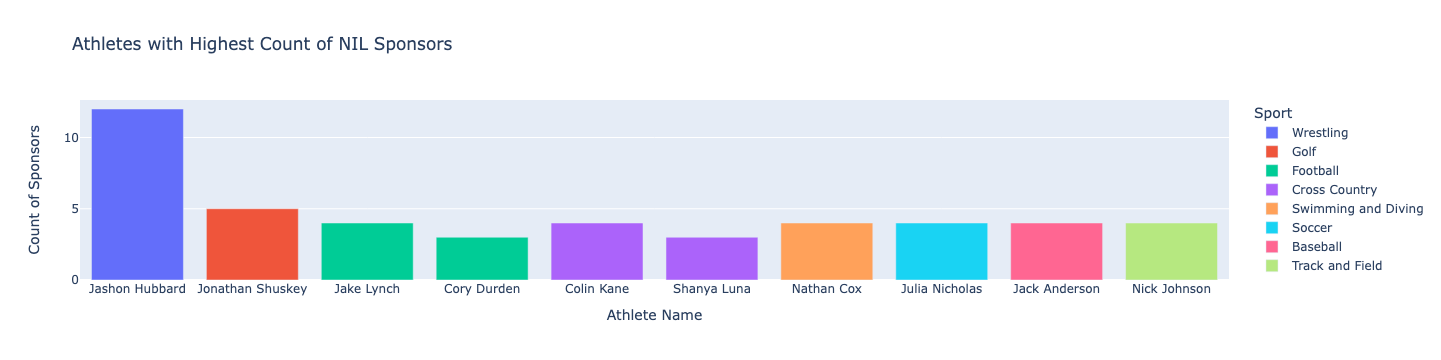

In [105]:
sponsors = df.groupby(['Name','Sport'], as_index=False)['Sponsor'].count()

sponsors = sponsors.sort_values(by='Sponsor', ascending=False)

sponsors_ct = sponsors[:10].sort_values(by='Sponsor', ascending=False)

fig1 = px.bar(sponsors_ct,x = 'Name', y = 'Sponsor', color='Sport',
      title="Athletes with Highest Count of NIL Sponsors",
                labels = {
                    'Name' : "Athlete Name",
                    'Sponsor': "Count of Sponsors"
                })
fig1.show()

In [11]:
pio.write_image(fig1,'fig1.png')
# default is 700 x 450; try 800 x 600

Sports with the most sponsorships

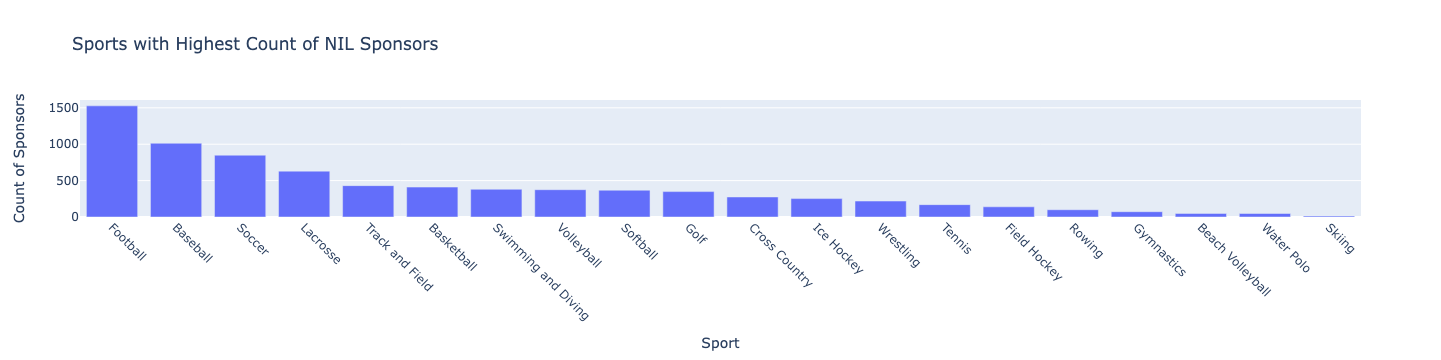

In [104]:
sport_spon = df.groupby(['Sport'], as_index=False)['Sponsor'].count()

sport_spon = sport_spon.sort_values(by='Sponsor', ascending=False)

sport_spon = sport_spon[:20]

fig2 = px.bar(sport_spon,x = 'Sport', y = 'Sponsor',
      title="Sports with Highest Count of NIL Sponsors",
                labels = {
                    'Sport' : "Sport",
                    'Sponsor': "Count of Sponsors"
                })
fig2.update_xaxes(tickangle=45)
fig2.show()

In [77]:
pio.write_image(fig2,'fig2.png')

box plot universities with most athlete NIL deals

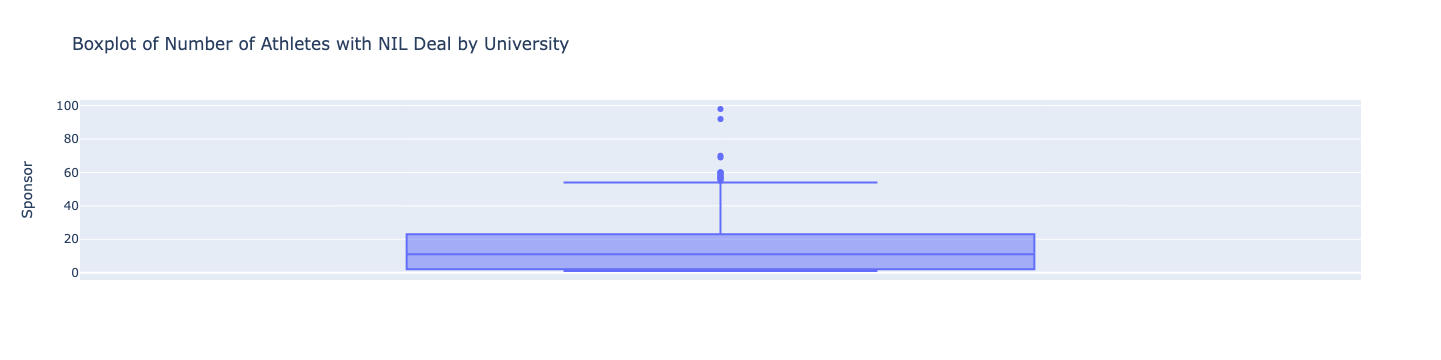

In [103]:
univ = df.groupby(['University'], as_index=False)['Sponsor'].count()

univ = univ.sort_values(by='Sponsor', ascending=False)

fig3 = px.box(univ,y='Sponsor', 
              hover_data = ['University'],
      title="Boxplot of Number of Athletes with NIL Deal by University")
fig3.show()

In [62]:
pio.write_image(fig3,'fig3.png')

Top Universities Bar Chart

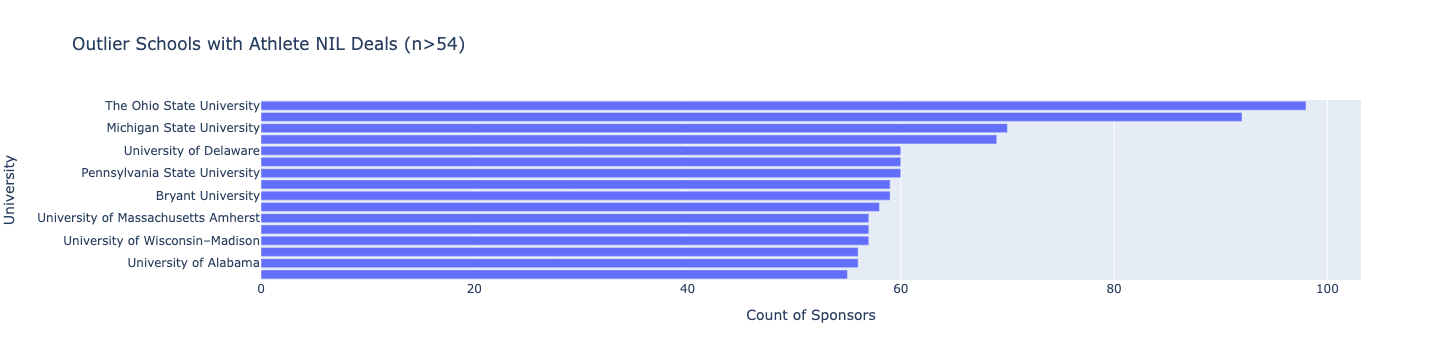

In [102]:
top_univ = univ.loc[univ['Sponsor']>54]

top_univ.sort_values(by='Sponsor', ascending=True)

fig4 = px.bar(top_univ, x = 'Sponsor', y = 'University',
       orientation='h',
      title = "Outlier Schools with Athlete NIL Deals (n>54)",
       labels = {
           'University' : 'University',
           'Sponsor' : 'Count of Sponsors'
       })
fig4.update_yaxes(autorange="reversed")
fig4.show()

In [79]:
pio.write_image(fig4,'fig4.png')

gender visualization

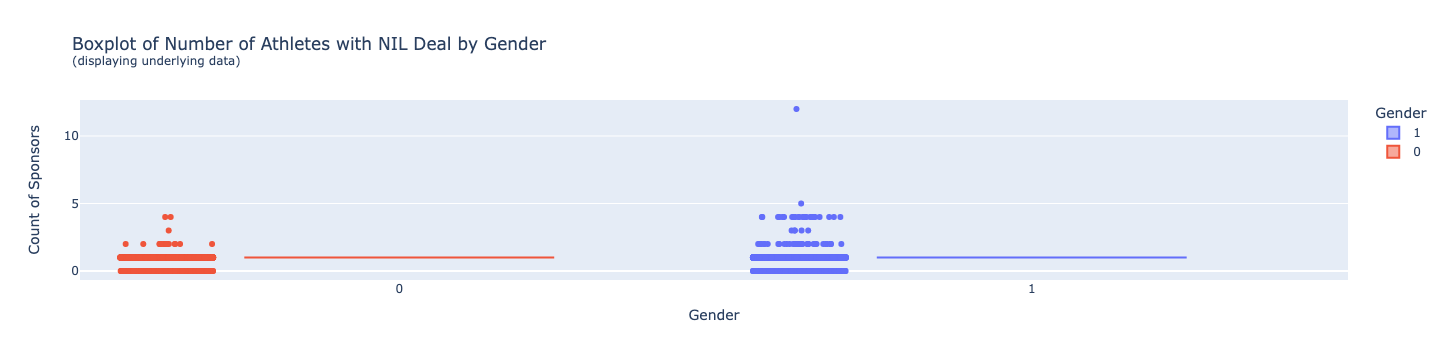

In [101]:
gend = df.groupby(['Name','Gender'], as_index=False)['Sponsor'].count()

gend = gend.sort_values(by='Sponsor', ascending=False)

fig5 = px.box(gend,x='Gender', y='Sponsor', points="all", color= 'Gender',
      title="Boxplot of Number of Athletes with NIL Deal by Gender <br><sup>(displaying underlying data)</sup>",
             labels = {'Sponsor' : 'Count of Sponsors'})
fig5.update_yaxes(minor_dtick=1)
fig5.show()

In [100]:
pio.write_image(fig5,'fig5.png')

## Not Using for Presentation

histogram sponsors count

In [15]:
hist = df.groupby(['Name','Gender'], as_index=False)['Sponsor'].count()

In [13]:
# hist= hist.loc[hist['Sponsor']>1]

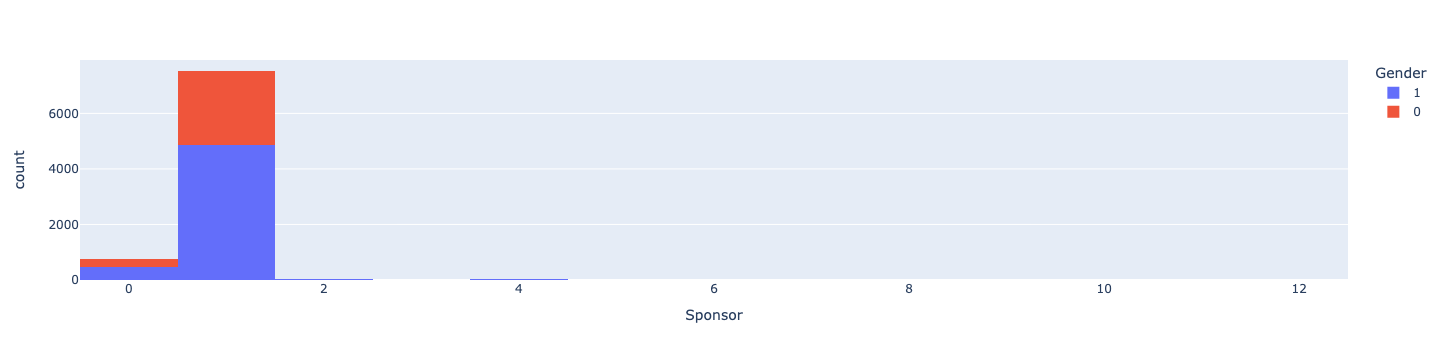

In [16]:
fig6 = px.histogram(hist, x='Sponsor', color='Gender')

fig6.show()

In [12]:
num_spon = df['Sponsor'].value_counts()
num_spon = pd.DataFrame(num_spon).reset_index()
num_spon.rename(columns = {'index':'Sponsor', 'Sponsor': 'Count'}, inplace = True)

In [13]:
num_spon = num_spon[:20]

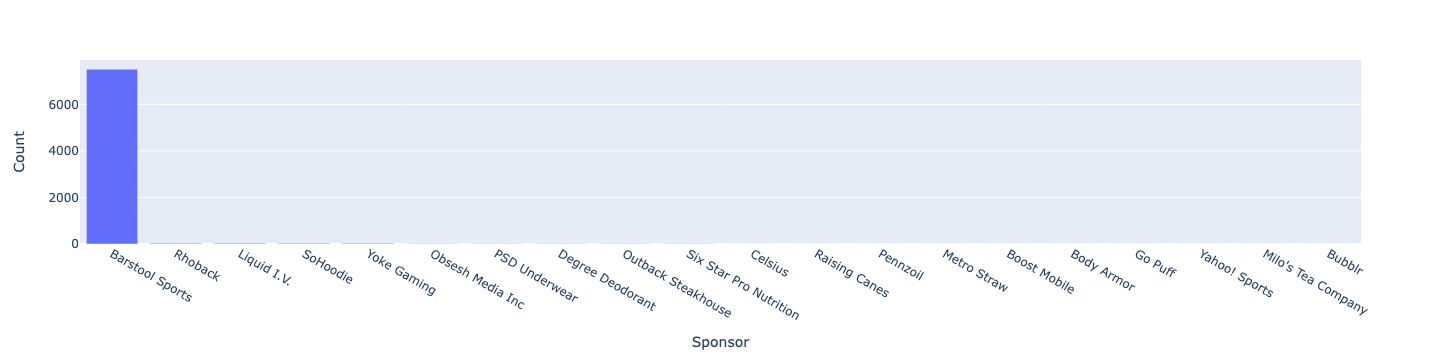

In [14]:
fig7 = px.bar(num_spon,x='Sponsor',y='Count')

fig7.show()

In [15]:
no_barstool = num_spon[1:21]

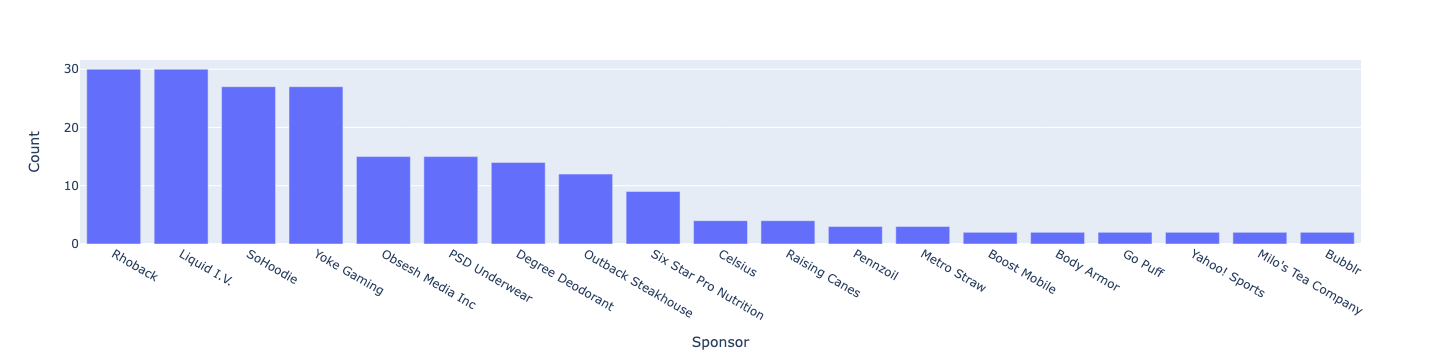

In [16]:
fig8 = px.bar(no_barstool,x='Sponsor',y='Count')

fig8.show()